In [1]:
! pip install torch torchvision transformers

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer
from transformers import BertModel
from PIL import Image
import requests
from io import BytesIO
import torch.optim as optim
import torch.nn as nn
import os
import pickle
from torchvision import models
from PIL import Image
import torch.nn.functional as F

In [3]:
from torchvision import transforms
from transformers import BertTokenizer
from PIL import Image
import requests
from io import BytesIO

In [4]:
df = pd.read_csv('coco_predictions.csv')
df.head()

,coco_url,captions,curious,amazed,fear,awe,neutral,disgusted,worried,intrigued,...,upset,concerned,good,hopeful,anger,joy,interested,calm,bored,scared
0,http://images.cocodataset.org/train2017/000000...,['A man with a red helmet on a small moped on ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,http://images.cocodataset.org/train2017/000000...,['A woman wearing a net on her head cutting a ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,http://images.cocodataset.org/train2017/000000...,['A child holding a flowered umbrella and pett...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,http://images.cocodataset.org/train2017/000000...,['A young boy standing in front of a computer ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,http://images.cocodataset.org/train2017/000000...,['a boy wearing headphones using one computer ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [5]:
import os
import numpy as np
import pandas as pd

# torch
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer

# from visualbert
from processing_image import Preprocess
from utils import Config
from modeling_frcnn import GeneralizedRCNN

class ImageProcessor:
    def __init__(self, device='cuda'):
        frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
        frcnn_cfg.MODEL.DEVICE = device
        self.device = device

        self.frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

        self.frcnn_cfg = frcnn_cfg
        self.image_preprocess = Preprocess(frcnn_cfg)

    def get_visual_embeddings(self, image_path):
        # run frcnn
        images, sizes, scales_yx = self.image_preprocess(image_path)

        output_dict = self.frcnn(
            images,
            sizes,
            scales_yx=scales_yx,
            padding="max_detections",
            max_detections=self.frcnn_cfg.max_detections,
            return_tensors="pt",
        )
        features = output_dict.get("roi_features").detach().cpu()
        return features

In [6]:
class CocoCaptionsDataset(Dataset):
    def __init__(self, dataframe, device='cuda'):
        self.dataframe = dataframe

        self.tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
        self.visual_extractor = ImageProcessor(device=device)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_url = row['coco_url']
        captions = eval(row['captions'])  # Evaluating the string to get the list and taking the first item

        # Image processing
        visual_embeds = self.visual_extractor.get_visual_embeddings(image_url)
        visual_token_type_ids = torch.ones(
            visual_embeds.shape[:-1], dtype=torch.long)
        visual_attention_mask = torch.ones(
            visual_embeds.shape[:-1], dtype=torch.float)

        # we need handle the fact that there are multiple captions (as opposed to one caption in Socratis)
        # We handle this by taking an average of the numeric values associated with the words
        input_ids_list = []
        token_type_ids_list = []
        attention_mask_list = []

        for caption in captions:
            inputs = self.tokenizer(caption, return_tensors="pt", max_length=32, truncation=True, padding='max_length')
            input_ids_list.append(inputs["input_ids"])
            token_type_ids_list.append(inputs["token_type_ids"])
            attention_mask_list.append(inputs["attention_mask"])

        input_ids = torch.cat(input_ids_list, dim=0).float().mean(dim=0).long()
        token_type_ids = torch.cat(token_type_ids_list, dim=0).float().mean(dim=0).long()
        attention_mask = torch.cat(attention_mask_list, dim=0).float().mean(dim=0).long()

        # Labels - extracting the last 29 columns as classes
        labels = torch.tensor(row[2:].values.astype(float), dtype=torch.float32)

        return (input_ids, token_type_ids, attention_mask, 
                visual_embeds, visual_token_type_ids, visual_attention_mask,
                labels)

In [7]:
#define student model architecture
num_emotions = 29
class StudentModel(nn.Module):
    def __init__(self, visualbert_model, device='cuda'):
        super(StudentModel, self).__init__()
        self.visualbert = visualbert_model
        self.fc = nn.Linear(self.visualbert.config.hidden_size, num_emotions)

    def forward(self, input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels):
        visualbert_outputs = self.visualbert(input_ids=input_ids.squeeze(1),
                                             attention_mask=attention_mask.squeeze(1),
                                             token_type_ids=token_type_ids.squeeze(1),
                                             visual_embeds=visual_embeds.squeeze(1),
                                            visual_token_type_ids=visual_token_type_ids.squeeze(1),
                                            visual_attention_mask=visual_attention_mask.squeeze(1))
        pooled_output = visualbert_outputs['pooler_output']
        

        # Emotion prediction
        logits = self.fc(pooled_output) # Loss function operates from logits

        return logits

In [8]:
from transformers import BertTokenizer, VisualBertModel,  BertConfig, BertModel

In [9]:
visualbert_model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
for param in visualbert_model.parameters():
    param.requires_grad = False

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Initialize model, optimizer, and loss function
student_model = StudentModel(visualbert_model)
student_model = student_model.to(device)  
optimizer = optim.Adam(student_model.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()

In [12]:
# Sample 10% of the data
sampled_df = df.sample(frac=0.1, random_state=42)  # Ensures reproducibility

# Proceed with dataset and dataloader setup
coco_dataset = CocoCaptionsDataset(sampled_df)
coco_loader = DataLoader(coco_dataset, batch_size=64, shuffle=False)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/ota231/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [13]:
coco_dataset[0]

/ext3/miniconda3/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(tensor([  101,  1430, 14785,  5188,  5199,  5028,  2004,  1669, 10543,  3609,
          4869,  4053,  3310,   202,    20,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 6.6697e-01],
          [7.3932e-01, 0.0000e+00, 2.8268e-03,  ..., 0.0000e+00,
           2.4698e-01, 2.9881e+00],
          [1.1296e+00, 1.2184e-02, 0.0000e+00,  ..., 2.6442e-01,
           1.4750e+00, 0.0000e+00],
          ...,
          [6.7559e-01, 0.0000e+00, 0.0000e+00,  ..., 4.0379e-02,
           3.5869e-01, 1.8167e+00],
          [1.4952e-01, 0.0000e+00, 0.0000e+00,  ..., 8.9899e-02,
           6.0466e-02,

In [14]:
import pickle

In [23]:
checkpoint_path = "student_checkpoints.pth"
log_file_path = './student_log.pickle'

In [24]:
def save_checkpoint(model, optimizer, epoch, batch_idx, loss, log, batch_data):
    torch.save({
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'batch_data': batch_data
    }, checkpoint_path)

    with open(log_file_path, 'wb') as f:
        pickle.dump(log, f)

In [25]:
def load_checkpoint(model, optimizer):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        batch_idx = checkpoint['batch_idx']
        loss = checkpoint['loss']
        log = pickle.load(open(log_file_path, 'rb'))
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch}, batch {batch_idx}")
        return start_epoch, batch_idx, loss, log, checkpoint['batch_data']
    else:
        print("No checkpoints found. Starting from epoch 1, batch 0")
        return 0, 0, 0, {'epoch':[], 'loss':[]}, None

In [44]:
start_epoch, start_batch, previous_loss, log, batch_data = load_checkpoint(student_model, optimizer)

Checkpoint loaded. Resuming from epoch 1, batch 184


In [37]:
start_epoch, start_batch, previous_loss, log, batch_data

(1,
 104,
 50.99548810720444,
 {'epoch': [], 'loss': []},
 [tensor([[  101,  3582,  4057,  ...,     0,     0,     0],
          [  101,  1475, 13806,  ...,     0,     0,     0],
          [  101,  1622,  2475,  ...,     0,     0,     0],
          ...,
          [  101,  1420,  4419,  ...,     0,     0,     0],
          [  101,  1228,  3235,  ...,     0,     0,     0],
          [  101,  1037,  4102,  ...,     0,     0,     0]]),
  tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]),
  tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]]),
  tensor([[[[5.8532e-03, 0.0000e+00, 6.9616e-01,  ..., 1.1962e+00,
             0.0000e+00, 4.7725e

In [38]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [45]:
num_epochs = 1
checkpoint_per_batch = 5
running_losses = []

In [41]:
from tqdm import tqdm

# Train student model
student_model.train()

for epoch in range(start_epoch - 1, num_epochs):
    if previous_loss == 0:
        running_loss = 0.0
    else:
        running_loss = previous_loss

    pbar = tqdm(enumerate(coco_loader), desc=f"Epoch {epoch}", total=len(coco_loader), dynamic_ncols=True, initial=start_batch)
    for batch_idx, batch in pbar:

        if epoch == start_epoch and batch_idx < start_batch:
            continue
        input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels = batch

        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        visual_embeds = visual_embeds.to(device)
        visual_token_type_ids = visual_token_type_ids.to(device)
        visual_attention_mask = visual_attention_mask.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through student model
        probabilities = student_model(input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels)

        # Compute loss
        loss = criterion(probabilities, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_losses.append(loss.item())

        # Update tqdm description with loss per batch
        pbar.set_postfix({'Loss (batch)': loss.item()})

        # Checkpoint per batch
        if (batch_idx + 1) % checkpoint_per_batch == 0:
            save_checkpoint(student_model, optimizer, epoch, batch_idx, running_loss, log, batch)

    # Print epoch loss
    print(f"Epoch {epoch}, Loss: {running_loss / len(coco_loader)}")

    # Save checkpoint at the end of the epoch
    save_checkpoint(student_model, optimizer, epoch, len(coco_loader) - 1, running_loss, log, batch)

    # log loss and determine when to stop
    log['epoch'].append(epoch+1)
    log['loss'].append(running_loss / len(coco_loader))

Epoch 0: 289it [1:18:13, 25.37s/it, Loss (batch)=0.367]                     


Epoch 0, Loss: 0.6611264504290916


In [42]:
torch.save(student_model.state_dict(), "trained_student_model.pth")

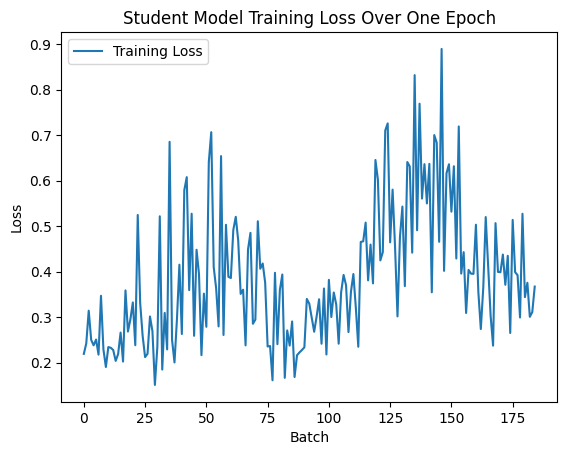

In [43]:
plt.plot(range(len(running_losses)), running_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Student Model Training Loss Over One Epoch')
plt.legend()
plt.show()